# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

## Dataset with Augmented Images + GLCM + 3 Folders 

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import sys, glob, time,re,string
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [22]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)


### Dataset Analysis

In [3]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [4]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


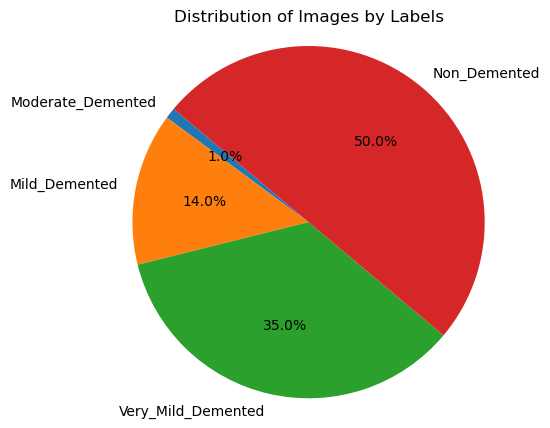

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [6]:
import shutil

source_dir = os.path.join(dataset_dir, "Very_Mild_Demented")
destination_dir = os.path.join(dataset_dir, "Mild_Demented")

for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(destination_dir, file_name)
    

    shutil.move(source_file, destination_file)
os.rmdir(source_dir)

In [7]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 3136
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


In [8]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

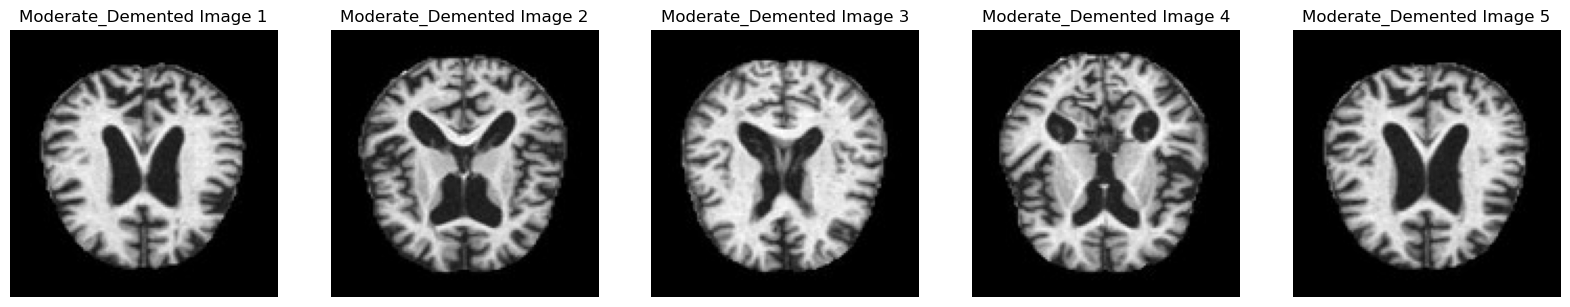

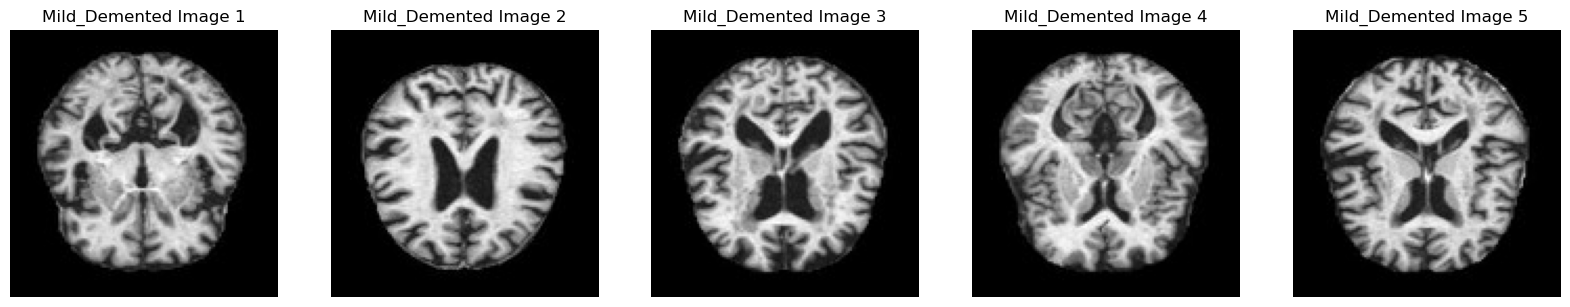

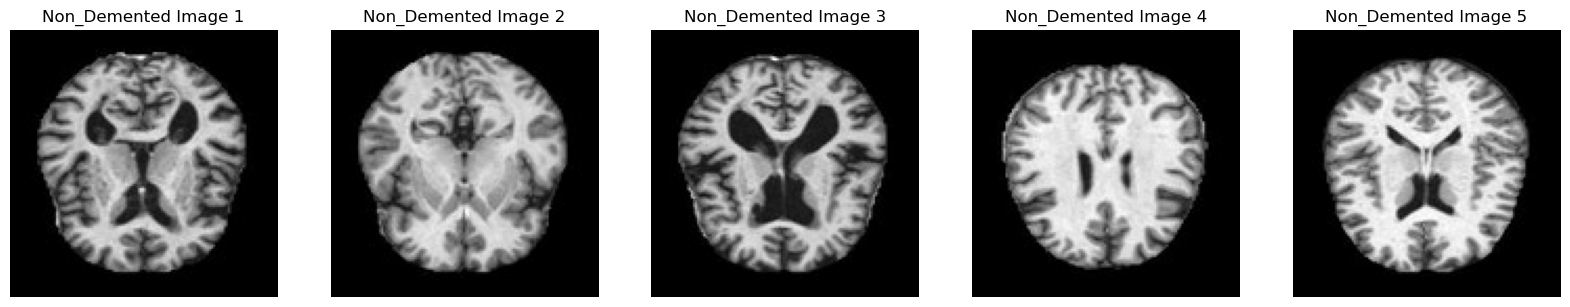

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [10]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [11]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

There is a significant imbalance in the data set, as we have already analysed.  A greater number of images have been included in some labels than others. It has been decided to use the Generative Model to perform augmentation to prevent any potential problems that this situation might cause. 

#### DCGAN

In [12]:
#parameters
img_width, img_height = 128, 128
batch_size=32
latent_dim = 128
epochs = 60

In [13]:
#directories
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
#Main Data
dataset = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode='categorical'
)
#Moderate Data
moderate_demented = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    classes=['Moderate_Demented']
)

Found 6400 images belonging to 3 classes.
Found 64 images belonging to 1 classes.


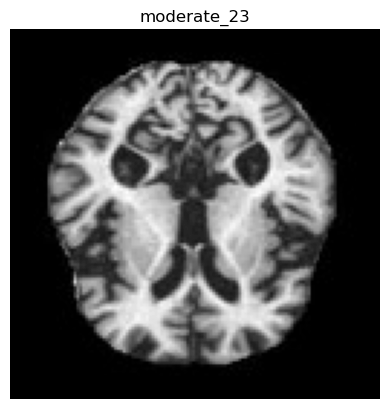

In [14]:
#Display random image from 'Moderate_Demented' class
moderate_dataset = os.path.join(dataset_dir, 'Moderate_Demented')
moderate_images = os.listdir(moderate_dataset)

img_name = np.random.choice(moderate_images)
img_path = os.path.join(moderate_dataset, img_name)

img = plt.imread(img_path)
img_name = os.path.splitext(img_name)[0]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(img_name)
plt.show()

Found 6400 files belonging to 3 classes.


2024-06-05 22:12:41.474705: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


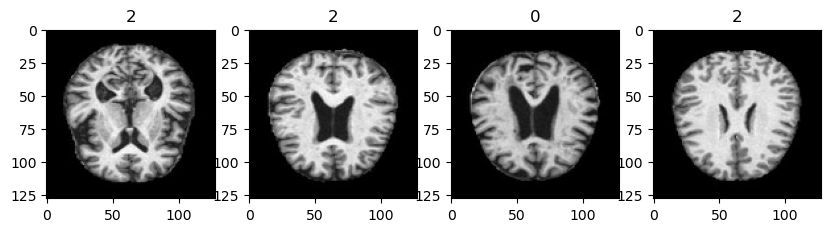

In [15]:
dataset_train = keras. utils.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = (img_width, img_height))

data_iterator = dataset_train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
train_gen = img_generator.flow_from_directory(
        dataset_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = None)

Found 6400 images belonging to 3 classes.


In [17]:
#Generator
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [18]:
#Discriminator
def discriminator_model():
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

In [19]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # loss metrics
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')


    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
        generated_images = self.generator(random_latent_vectors)
    
        combined_images = tf.concat([generated_images, real_images], axis=0)
    
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # Adding noise to labels

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}


In [20]:
#Monitor and saving images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_images=10, output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented'):
        self.latent_dim = latent_dim
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_images, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_images):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png")
            img.save(img_path)

In [23]:
dcgan_monitor = DCGANMonitor(output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented')

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim)
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0001, beta_1= 0.0001), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.0001), loss_fn = BinaryCrossentropy())

# fit the model and save the history
history = dcgan.fit(train_gen, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/60
200/200 [==============================] - 97s 481ms/step - d_loss: 0.6942 - g_loss: 0.7628
Epoch 2/60
200/200 [==============================] - 97s 487ms/step - d_loss: 0.6971 - g_loss: 0.7546
Epoch 3/60
200/200 [==============================] - 94s 467ms/step - d_loss: 0.6974 - g_loss: 0.7543
Epoch 4/60
200/200 [==============================] - 94s 471ms/step - d_loss: 0.6970 - g_loss: 0.7533
Epoch 5/60
200/200 [==============================] - 98s 488ms/step - d_loss: 0.6962 - g_loss: 0.7537
Epoch 6/60
200/200 [==============================] - 95s 476ms/step - d_loss: 0.6966 - g_loss: 0.7524
Epoch 7/60
200/200 [==============================] - 94s 472ms/step - d_loss: 0.6971 - g_loss: 0.7501
Epoch 8/60
200/200 [==============================] - 96s 482ms/step - d_loss: 0.6964 - g_loss: 0.7490
Epoch 9/60
200/200 [==============================] - 97s 483ms/step - d_loss: 0.6963 - g_loss: 0.7462
Epoch 10/60
200/200 [==============================] - 97s 486ms/step - d

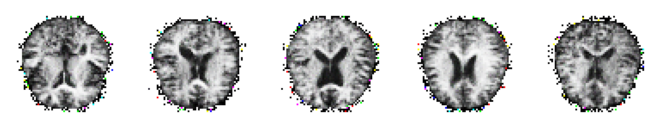

In [24]:
plt.figure(figsize=(10, 10))

for i in range(5):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 128])
    mg = dcgan.generator(noise)
    
    #denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

After successfully finishing the data augmentation stage, we chose to randomly choose a number of images loaded with data folders to balance the distribution of labels in the dataset.

In [25]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
   
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Mild_Demented")

num_delete_nd = 2000
num_delete_vmd = 2000
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)

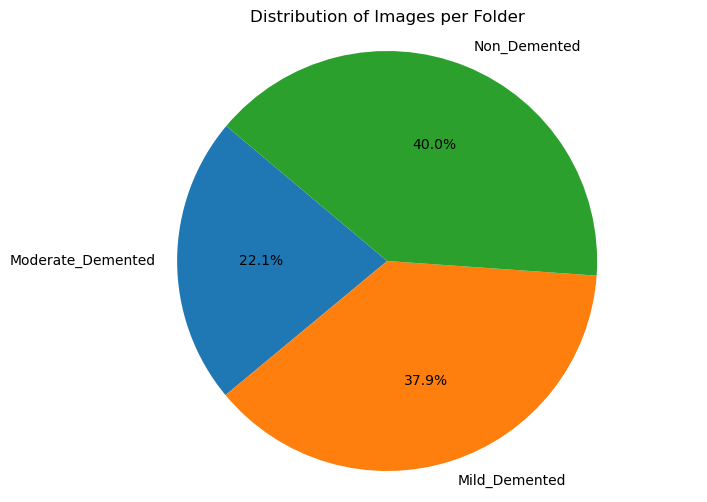

Number of Images in Each Folder:
Moderate_Demented: 664 images
Mild_Demented: 1136 images
Non_Demented: 1200 images


In [26]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

As we can see in the piechart, the dataset is not more balanced and ready to be worked with.

### Grey Level Co-occurrence Matrix (GLCM)

In [27]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [28]:
dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
...,...,...
2995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented


In [29]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [30]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,1103.392857,18.086806,0.485169,0.461950,0.895203
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,993.016865,16.964782,0.449450,0.408554,0.937243
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,946.921627,16.394841,0.474224,0.441578,0.929620
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,985.159722,16.963790,0.466000,0.428997,0.939417
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,1104.279266,17.890377,0.462947,0.429876,0.924943
...,...,...,...,...,...,...,...
2995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,317.840059,9.385458,0.471634,0.409150,0.980493
2996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,265.699188,8.755290,0.463823,0.398410,0.978158
2997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,324.593504,9.934670,0.449123,0.393315,0.976762
2998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,343.651575,9.943159,0.450167,0.388850,0.977299


In [31]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,1103.392857,18.086806,0.485169,0.461950,0.895203
1,993.016865,16.964782,0.449450,0.408554,0.937243
2,946.921627,16.394841,0.474224,0.441578,0.929620
3,985.159722,16.963790,0.466000,0.428997,0.939417
4,1104.279266,17.890377,0.462947,0.429876,0.924943
...,...,...,...,...,...
2995,317.840059,9.385458,0.471634,0.409150,0.980493
2996,265.699188,8.755290,0.463823,0.398410,0.978158
2997,324.593504,9.934670,0.449123,0.393315,0.976762
2998,343.651575,9.943159,0.450167,0.388850,0.977299


In [32]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    accuracy = classification_report(y_test, y_pred)
    print("classification_report:", accuracy)

In [33]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10)
ml_models(rf_model, X, y)

Accuracy: 0.7566666666666667
classification_report:                    precision    recall  f1-score   support

    Mild_Demented       0.67      0.73      0.70       226
Moderate_Demented       0.99      0.92      0.96       150
     Non_Demented       0.70      0.68      0.69       224

         accuracy                           0.76       600
        macro avg       0.79      0.77      0.78       600
     weighted avg       0.76      0.76      0.76       600



In [34]:
#GAUSSIAN NB
gnb_model = GaussianNB()
ml_models(gnb_model, X, y)

Accuracy: 0.705
classification_report:                    precision    recall  f1-score   support

    Mild_Demented       0.63      0.57      0.60       226
Moderate_Demented       1.00      0.92      0.96       150
     Non_Demented       0.61      0.70      0.65       224

         accuracy                           0.70       600
        macro avg       0.75      0.73      0.74       600
     weighted avg       0.71      0.70      0.71       600



In [35]:
#DECISION TREE
dt_model = DecisionTreeClassifier()
ml_models(dt_model, X, y)

Accuracy: 0.6833333333333333
classification_report:                    precision    recall  f1-score   support

    Mild_Demented       0.61      0.54      0.57       226
Moderate_Demented       0.92      0.94      0.93       150
     Non_Demented       0.60      0.65      0.62       224

         accuracy                           0.68       600
        macro avg       0.71      0.71      0.71       600
     weighted avg       0.68      0.68      0.68       600



In [36]:
#SVM
svm_model = SVC(kernel='linear', random_state=42)
ml_models(svm_model, X, y)

Accuracy: 0.7
classification_report:                    precision    recall  f1-score   support

    Mild_Demented       0.62      0.58      0.60       226
Moderate_Demented       1.00      0.92      0.96       150
     Non_Demented       0.60      0.67      0.64       224

         accuracy                           0.70       600
        macro avg       0.74      0.72      0.73       600
     weighted avg       0.71      0.70      0.70       600



In [37]:
#LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ml_models(lr_model, X, y)

Accuracy: 0.705
classification_report:                    precision    recall  f1-score   support

    Mild_Demented       0.63      0.58      0.60       226
Moderate_Demented       1.00      0.92      0.96       150
     Non_Demented       0.61      0.69      0.65       224

         accuracy                           0.70       600
        macro avg       0.75      0.73      0.74       600
     weighted avg       0.71      0.70      0.71       600



In [38]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [39]:
#Train data
Images, Labels = get_images("./alzheimer-mri-dataset/Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [40]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [42]:
from collections import Counter
Counter(encoded_labels)

Counter({2: 1200, 0: 1136, 1: 664})

### Deep Learning

In [43]:
#Function for deep learning approaches
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=3):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [44]:
#EfficientNetB0
efficientnet_model = deep_learning(EfficientNetB0)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_eff = efficientnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              83890176  
                                                                 
 dense_3 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 32)               

Epoch 1/100
75/75 [==============================] - 27s 326ms/step - loss: 0.6754 - accuracy: 0.6475 - val_loss: 0.5474 - val_accuracy: 0.7467
Epoch 2/100
75/75 [==============================] - 21s 279ms/step - loss: 0.5685 - accuracy: 0.7113 - val_loss: 0.4584 - val_accuracy: 0.7717
Epoch 3/100
75/75 [==============================] - 22s 289ms/step - loss: 0.5104 - accuracy: 0.7446 - val_loss: 0.4504 - val_accuracy: 0.7933
Epoch 4/100
75/75 [==============================] - 20s 259ms/step - loss: 0.4576 - accuracy: 0.7663 - val_loss: 0.4141 - val_accuracy: 0.8150
Epoch 5/100
75/75 [==============================] - 19s 255ms/step - loss: 0.4405 - accuracy: 0.7783 - val_loss: 0.3899 - val_accuracy: 0.8017
Epoch 6/100
75/75 [==============================] - 20s 261ms/step - loss: 0.4216 - accuracy: 0.7921 - val_loss: 0.3843 - val_accuracy: 0.8167
Epoch 7/100
75/75 [==============================] - 19s 259ms/step - loss: 0.3895 - accuracy: 0.8142 - val_loss: 0.3751 - val_accuracy:

In [45]:
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

19/19 [==============================] - 3s 133ms/step
F1 Score: 0.9182400614979135
Recall: 0.9183333333333333
Precision: 0.9192604741947697
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89       224
           1       1.00      1.00      1.00       147
           2       0.87      0.92      0.90       229

    accuracy                           0.92       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.92      0.92      0.92       600



In [46]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_9 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 32)               

Epoch 1/100
75/75 [==============================] - 91s 1s/step - loss: 1.0490 - accuracy: 0.6425 - val_loss: 0.5516 - val_accuracy: 0.7083
Epoch 2/100
75/75 [==============================] - 87s 1s/step - loss: 0.4503 - accuracy: 0.7792 - val_loss: 0.4523 - val_accuracy: 0.7650
Epoch 3/100
75/75 [==============================] - 87s 1s/step - loss: 0.3431 - accuracy: 0.8475 - val_loss: 0.4070 - val_accuracy: 0.8033
Epoch 4/100
75/75 [==============================] - 85s 1s/step - loss: 0.2688 - accuracy: 0.8863 - val_loss: 0.4798 - val_accuracy: 0.7667
Epoch 5/100
75/75 [==============================] - 83s 1s/step - loss: 0.1974 - accuracy: 0.9187 - val_loss: 0.3516 - val_accuracy: 0.8433
Epoch 6/100
75/75 [==============================] - 82s 1s/step - loss: 0.1435 - accuracy: 0.9517 - val_loss: 0.3773 - val_accuracy: 0.8367
Epoch 7/100
75/75 [==============================] - 82s 1s/step - loss: 0.1094 - accuracy: 0.9675 - val_loss: 0.3569 - val_accuracy: 0.8683
Epoch 8/100
7

In [47]:
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

19/19 [==============================] - 16s 846ms/step
F1 Score: 0.9017788852192863
Recall: 0.9016666666666666
Precision: 0.9019383259911895
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       224
           1       1.00      0.99      1.00       147
           2       0.88      0.87      0.87       229

    accuracy                           0.90       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.90      0.90      0.90       600



In [48]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_14 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_15 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_16 (Dense)            (None, 256)               262400    
                                                                 
 dense_17 (Dense)            (None, 64)                16448     
                                                                 
 dense_18 (Dense)            (None, 32)               

Epoch 1/100
75/75 [==============================] - 58s 761ms/step - loss: 0.7486 - accuracy: 0.6542 - val_loss: 0.4636 - val_accuracy: 0.7767
Epoch 2/100
75/75 [==============================] - 59s 791ms/step - loss: 0.5132 - accuracy: 0.7346 - val_loss: 0.4356 - val_accuracy: 0.8183
Epoch 3/100
75/75 [==============================] - 55s 728ms/step - loss: 0.3965 - accuracy: 0.8108 - val_loss: 0.4452 - val_accuracy: 0.8000
Epoch 4/100
75/75 [==============================] - 54s 726ms/step - loss: 0.3504 - accuracy: 0.8413 - val_loss: 0.3806 - val_accuracy: 0.8250
Epoch 5/100
75/75 [==============================] - 60s 794ms/step - loss: 0.2934 - accuracy: 0.8646 - val_loss: 0.7409 - val_accuracy: 0.6867
Epoch 6/100
75/75 [==============================] - 60s 799ms/step - loss: 0.2605 - accuracy: 0.8783 - val_loss: 0.3748 - val_accuracy: 0.8167
Epoch 7/100
75/75 [==============================] - 63s 846ms/step - loss: 0.1952 - accuracy: 0.9208 - val_loss: 0.3891 - val_accuracy:

In [49]:
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

19/19 [==============================] - 7s 326ms/step
F1 Score: 0.8815650498732229
Recall: 0.8816666666666667
Precision: 0.882216451486698
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       224
           1       1.00      1.00      1.00       147
           2       0.83      0.87      0.85       229

    accuracy                           0.88       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.88      0.88      0.88       600

